## Семинар 7: "Методы оптимизации"

ФИО: Евстифеев Степан Александрович

In [384]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [385]:
class Optimizer(object):
    def __init__(self, func, deriv, weight_init):
        self.func = func
        self.deriv = deriv
        self.theta = np.array(weight_init, dtype='float64')
    
    def step(self):
        raise NotImplementedError()


In [386]:
class GD(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.1):
        super(GD, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        
    def step(self):
        self.theta = self.theta - self.learning_rate * self.deriv(self.theta)

In [387]:
class Momentum(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.1, gamma=0.9):
        super(Momentum, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.vt = 0
    
    def step(self):
        self.vt = self.gamma * self.vt + self.learning_rate * self.deriv(self.theta)
        self.theta = self.theta - self.vt

In [388]:
class NAG(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.1, gamma=0.9):
        super(NAG, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.vt = 0
    
    def step(self):
        self.vt = self.gamma * self.vt + self.learning_rate * self.deriv(self.theta - self.gamma * self.vt)
        self.theta = self.theta - self.vt

In [389]:
class Adagrad(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.01, eps=1e-8):
        super(Adagrad, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        self.eps = eps
        self.G = np.zeros_like(self.theta, dtype='float64')
        
    def step(self):
        grad = self.deriv(self.theta)
        self.G += grad ** 2
        self.theta -= self.learning_rate / np.sqrt(self.G + self.eps) * grad

In [495]:
class Adadelta(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.1, eps=1e-8, gamma=0.9):
        super(Adadelta, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        self.eps = eps
        self.expG = np.zeros_like(self.theta, dtype='float64')
        self.gamma = gamma
        self.delta = np.zeros_like(self.theta, dtype='float64')
    
    def step(self):
        grad = self.deriv(self.theta)
        self.expG = self.gamma * self.expG + (1 - self.gamma) * grad ** 2
        delta = self.learning_rate * np.sqrt((self.delta + self.eps) / (self.expG + self.eps)) * grad
        self.delta = self.gamma * self.delta + (1 - self.gamma) * delta ** 2
        self.theta -= delta

In [496]:
class Adam(Optimizer):
    def __init__(self, func, deriv, weight_init, learning_rate=0.01, eps=1e-8, b1=0.9, b2=0.999):
        super(Adam, self).__init__(func, deriv, weight_init)
        self.learning_rate = learning_rate
        self.eps = eps
        self.mt = np.zeros_like(self.theta, dtype='float64')
        self.vt = np.zeros_like(self.theta, dtype='float64')
        self.b1 = b1
        self.b2 = b2
        self.iter = 0
    
    def step(self):
        self.iter += 1
        grad = self.deriv(self.theta)
        self.mt = self.b1 * self.mt + (1 - self.b1) * grad
        self.vt = self.b2 * self.vt + (1 - self.b2) * (grad ** 2)
        mt_cor = self.mt / (1 - self.b1 ** self.iter)
        vt_cor = self.vt / (1 - self.b2 ** self.iter)
        self.theta -= self.learning_rate * mt_cor / (np.sqrt(vt_cor + self.eps)) 

In [497]:
def contour_plot(func, x_s, x_e, y_s, y_e, delta=0.05):
    x = np.arange(x_s, x_e, delta)
    y = np.arange(y_s, y_e, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func(x) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, fmt='%1.1f', inline=1, fontsize=10)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

GD: [2.44444317e-10 1.42592518e-10]
Momentum: [-0.00342169 -0.00199599]
NAG: [-3.68171970e-08 -2.14766982e-08]
Adagrad: [1.01965985 0.52394742]
Adadelta: [1.19890221 0.69890226]
Adam: [0.3797941  0.04523864]


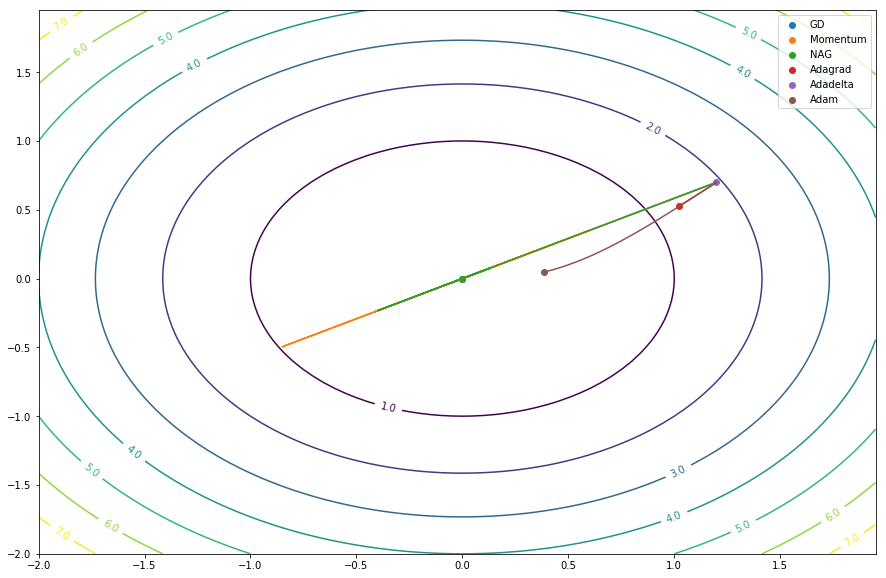

In [498]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

optimizers = [GD, Momentum, NAG, Adagrad, Adadelta, Adam]
plt.figure(figsize=(15, 10))
contour_plot(f, -2, 2, -2, 2)
ITER_NUM = 100
START_POINT = (1.2, 0.7)
for meta_optimizer in optimizers:
    thetas = np.empty((ITER_NUM, 2))
    optimizer = meta_optimizer(f, df, START_POINT)
    for i in range(ITER_NUM):
        thetas[i] = optimizer.theta
        optimizer.step()
    plt.scatter(thetas[-1, 0], thetas[-1, 1], label = optimizer.__class__.__name__)
    plt.plot(thetas[:, 0], thetas[:, 1])
    print("{0}: {1}".format(optimizer.__class__.__name__, optimizer.theta))
plt.legend()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

GD: [0.00033299 0.00033311]
Momentum: [-2.28892973 -2.28892973]
NAG: [-2.28892973 -2.28892973]
Adagrad: [0.12182582 0.462106  ]
Adadelta: [0.89941717 1.89938433]
Adam: [4.22388212e-05 1.12561106e-04]


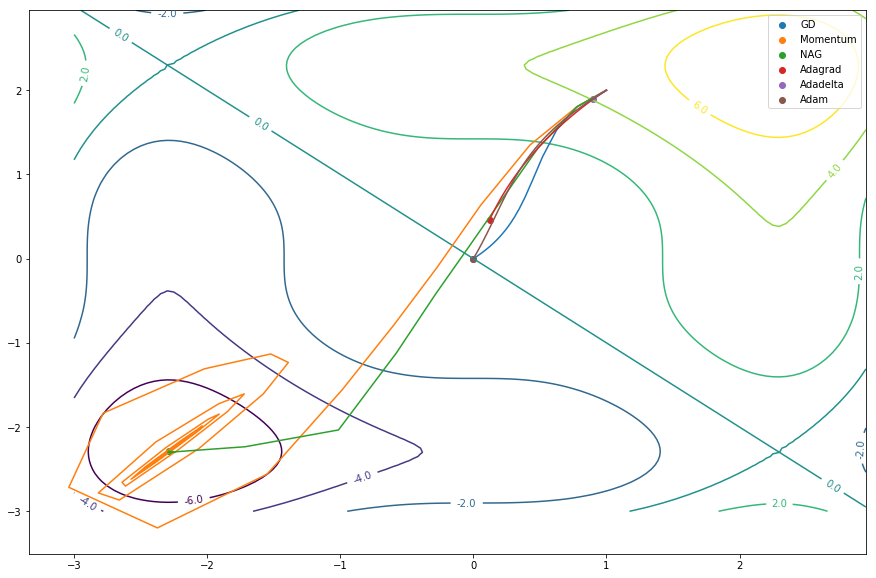

In [499]:
f = lambda X: (X[0] ** 2) * np.sin(X[0]) + (X[1]**2) * np.sin(X[1])
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + X[0]**2 * np.cos(X[0]), 2*X[1]*np.sin(X[1]) + X[1]**2 * np.cos(X[1])])

optimizers = [GD, Momentum, NAG, Adagrad, Adadelta, Adam]
plt.figure(figsize=(15, 10))
contour_plot(f, -3, 3, -3, 3)
ITER_NUM = 10000
START_POINT = (1, 2)
for meta_optimizer in optimizers:
    thetas = np.empty((ITER_NUM, 2))
    optimizer = meta_optimizer(f, df, START_POINT)
    for i in range(ITER_NUM):
        thetas[i] = optimizer.theta
        optimizer.step()
    plt.scatter(thetas[-1, 0], thetas[-1, 1], label = optimizer.__class__.__name__)
    plt.plot(thetas[:, 0], thetas[:, 1])
    print("{0}: {1}".format(optimizer.__class__.__name__, optimizer.theta))
plt.legend()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

GD: [2.21656952 0.15280588]
Momentum: [2.21656952 0.00351624]
NAG: [2.21656952 0.03026078]
Adagrad: [2.04945089 0.30991263]
Adadelta: [1.50050923 0.59949085]
Adam: [2.21656952 0.06043852]


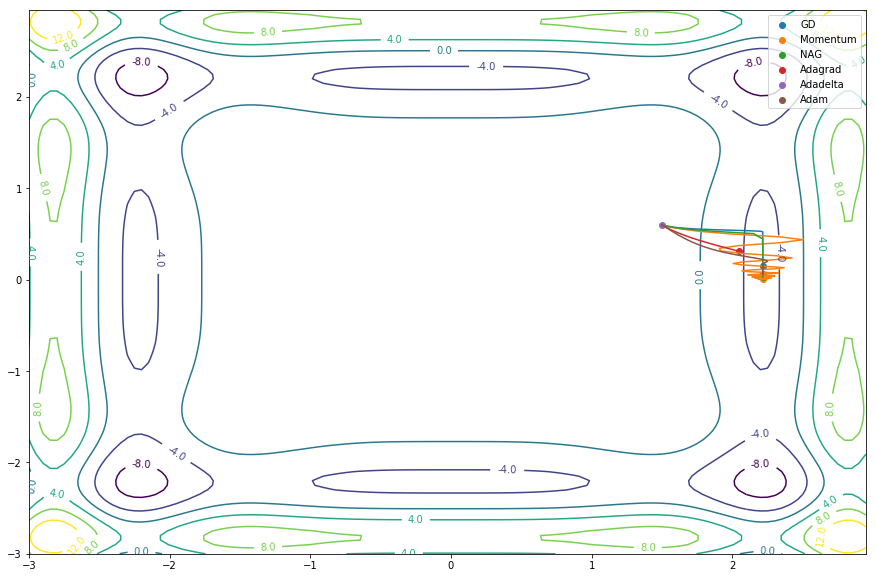

In [503]:
f = lambda X: (X[0] ** 2) * np.sin(X[0]**2) + (X[1]**2) * np.sin(X[1]**2)
df = lambda X: np.array([
    2 * X[0] * np.sin(X[0] ** 2) + 2 * (X[0] ** 3) * np.cos(X[0]**2),
    2 * X[1] * np.sin(X[1] ** 2) + 2 * (X[1] ** 3) * np.cos(X[1]**2)
])

optimizers = [GD, Momentum, NAG, Adagrad, Adadelta, Adam]
#optimizers = [GD, Momentum, NAG, Adagrad, Adadelta]
plt.figure(figsize=(15, 10))
contour_plot(f, -3, 3, -3, 3)
ITER_NUM = 500
START_POINT = [1.5, 0.6]
for meta_optimizer in optimizers:
    thetas = np.empty((ITER_NUM, 2))
    optimizer = meta_optimizer(f, df, START_POINT, learning_rate=0.01)
    for i in range(ITER_NUM):
        thetas[i] = optimizer.theta
        optimizer.step()
    plt.scatter(thetas[-1, 0], thetas[-1, 1], label = optimizer.__class__.__name__)
    plt.plot(thetas[:, 0], thetas[:, 1])
    print("{0}: {1}".format(optimizer.__class__.__name__, optimizer.theta))
plt.legend();

###  Часть 2: Обучение нейронной сети

In [504]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data/mnist', train=False, download=True, transform=transform)
test_dataset = MNIST('../data/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [541]:
def train(network, epochs, learning_rate, optim, on_cuda=True, device="cuda"):
    loss = nn.NLLLoss().cuda() if on_cuda else nn.NLLLoss()
    optimizer = optim
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if on_cuda:
                    X, y = X.cuda(), y.cuda()
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if on_cuda:
                    X, y = X.cuda(), y.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [525]:
class ForwardNet(nn.Module):
    def __init__(self):
        super(ForwardNet, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 300), 
                                           nn.ReLU(), 
                                           nn.Linear(300, 300), 
                                           nn.ReLU(),
                                           nn.Linear(300, 10),
                                           nn.LogSoftmax(1))
    
    def forward(self, x):
        x = x.view(-1, 784).cuda()
        x = self.linear_layers(x)
        return x

In [539]:
lr = 0.01
sgd = torch.optim.SGD
adagrad = torch.optim.Adagrad
adadelta = torch.optim.Adadelta
adam = torch.optim.Adam

optimizers = [adagrad, sgd, adadelta, adam]
opt_names = ["adagrad", "sgd", "adadelta", "adam"]
ITER_NUM = 30
train_optim_losses = np.empty((len(optimizers), ITER_NUM))
test_optim_losses = np.empty((len(optimizers), ITER_NUM))

for i, (opt_name, optimizer) in enumerate(zip(opt_names, optimizers)):
    network = ForwardNet().cuda()
    opt = optimizer(network.parameters(), lr = lr)
    tr_l, te_l, tr_a, te_a = train(network, ITER_NUM, lr, opt)
    print("Optimizator finished {0} with {1:.2f} loss".format(opt_name, te_l[-1]))
    train_optim_losses[i] = tr_l
    test_optim_losses[i] = te_l

Optimizator finished adagrad with 0.00 loss
Optimizator finished sgd with 0.28 loss
Optimizator finished adadelta with 0.33 loss
Optimizator finished adam with 0.07 loss


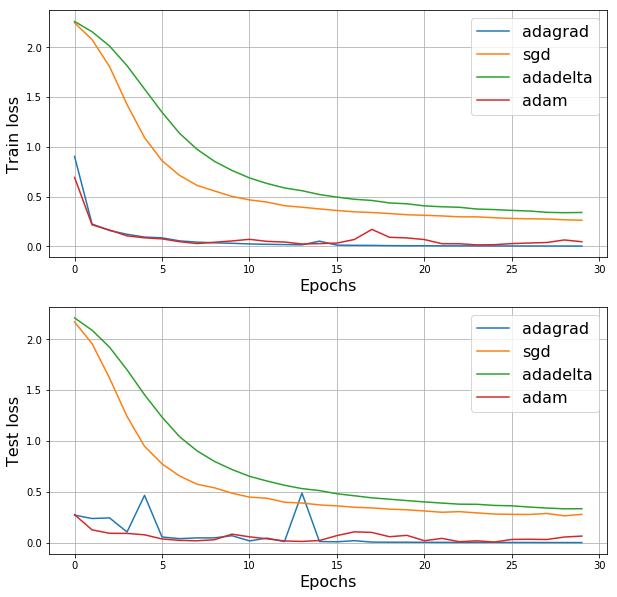

In [540]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, opt_name in enumerate(opt_names):
    plt.plot(train_optim_losses[i], label=opt_name)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Train loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)

plt.subplot(2, 1, 2)

for i, opt_name in enumerate(opt_names):
    plt.plot(test_optim_losses[i], label=opt_name)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Test loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

Методы **sgd и adadelta** работают сравнительно медленно в данной задаче. Сходимость наступает на ~25 эпохе.

Методы **adam и adagrad** сходяться практически сразу же к оптимальному значению на ~5 эпохе.

Судя по графикам, adam сходиться быстрее к локальному минимум, при этом выдавая стабильные значения на тестовых данных. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: